In [927]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import GridSearchCV, cross_validate


All questions in this section pertain to two of the datasets listed above in Exam Materials
(training_set_data.csv and unlabeled_data.csv), with the data_dictionary.txt file providing the
metadata needed to understand the contents and formats of each .csv. 

Please note that the data is still in its raw, original form and may require some cleaning and/or standardization.


Imagine we are being asked by one of our clients, ACME X, to predict if a given individual is
uninsured or not (health insurance). Using the data in training_set_data.csv, please train a model
to predict whether each person in the data set is uninsured or not. 


Furthermore, our main contact
at ACME X will need to explain the basics of the model to their smart, but non-technical
coworkers, so interpretability of how the model inputs relate to the predictions will be important.

In [935]:
train = pd.read_csv('training_set_data.csv')
pd.set_option('display.max_columns', 500)
train.head(3)

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,uninsured,household_id
0,1,45,citizen_birth,native_born,15,908.0,62.0,800.0,11.0,35.0,married,not_student,FEMALE,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
1,2,47,citizen_birth,native_born,50,180499.0,49.0,160007.0,20424.0,19.0,married,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
2,4,26,citizen_birth,native_born,0,7367.0,93.0,4.0,20.0,7250.0,never_married,not_student,male,over_five_years_ago,not_reported,English,0,0,1,0,0,0,0,0,2


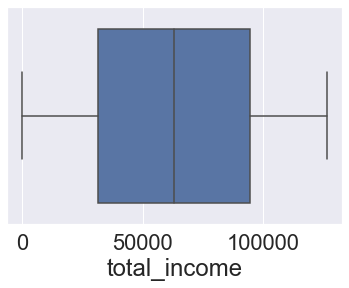

In [951]:
sns.boxplot(train.total_income)

In [950]:
train.total_income.mean()

63105.708648667074

In [967]:
train = train.loc[train.total_income < 250000]

## EDA

In [968]:
train.sex = train.sex.replace({'FEMALE': 'F'})
train.sex = train.sex.replace({'female': 'F'})

train.sex = train.sex.replace({'MALE': 'M'})
train.sex = train.sex.replace({'male': 'M'})

train.sex.value_counts()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


F    30606
M    28062
Name: sex, dtype: int64

In [969]:
train.language.value_counts(normalize=True).count()

2

In [970]:
for val in train.language.values:
    if val != 'English':
        train.language = train.language.replace({val:'not_english'})


In [971]:
train.language.value_counts()

English        48498
not_english    10170
Name: language, dtype: int64

In [972]:
train.race_native_hawaiian.value_counts()

0    58648
1       20
Name: race_native_hawaiian, dtype: int64

In [973]:
unlabeled = pd.read_csv('unlabeled_data.csv')
pd.set_option('display.max_columns', 500)
# unlabeled.head()

In [974]:
train.head()

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,uninsured,household_id
0,1,45,citizen_birth,native_born,15,1,62.0,800.0,11.0,35.0,married,not_student,F,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
1,2,47,citizen_birth,native_born,50,2,49.0,160007.0,20424.0,19.0,married,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
2,4,26,citizen_birth,native_born,0,4,93.0,4.0,20.0,7250.0,never_married,not_student,M,over_five_years_ago,not_reported,English,0,0,1,0,0,0,0,0,2
3,5,42,citizen_naturalized,foreign_born,0,5,51.0,46.0,283.0,22590.0,never_married,public_school,M,in_last_five_years,did_not_work,not_english,0,1,0,0,0,0,0,0,3
4,6,79,citizen_naturalized,foreign_born,0,6,23.0,94.0,73.0,7751.0,married,not_student,M,over_five_years_ago,did_not_work,not_english,0,1,0,0,0,0,0,0,3


In [975]:
#Target and independent variables

X = train.drop(['person_id', 'uninsured', 'household_id',  
                 ],  axis=1)
y= train['uninsured']


In [976]:
y.value_counts(normalize=True)

0    0.921388
1    0.078612
Name: uninsured, dtype: float64

## One hot encoder

In [977]:
train.isna().sum()

person_id                0
age                      0
citizen_status           0
nativity_status          0
weekly_hours_worked      0
total_income             0
self_employed_income     0
wage_income              0
interest_income          0
other_income             0
marital_status           0
school_status            0
sex                      0
when_last_worked         0
worked_last_week         0
language                 0
race_native_american     0
race_asian               0
race_black               0
race_native_hawaiian     0
race_pacific_islander    0
race_white               0
race_other               0
uninsured                0
household_id             0
dtype: int64

In [978]:
cont = X.select_dtypes(exclude='object')

cat = X.select_dtypes(include='object')

###  Scaling cont  variables 

In [979]:
for col in cont.columns:
    cont[col]= (cont[col]-min(cont[col]))/(max(cont[col]-min(cont[col])))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [980]:
cont = cont.round(2)
cont.head()

,age,weekly_hours_worked,self_employed_income,wage_income,interest_income,other_income,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other
0,0.36,0.15,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.38,0.51,0.0,0.64,0.08,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.11,0.00,0.0,0.00,0.00,0.03,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.32,0.00,0.0,0.00,0.00,0.09,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.80,0.00,0.0,0.00,0.00,0.03,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [981]:
ehe = OneHotEncoder(drop='first')


In [982]:
tran = ehe.fit_transform(cat).toarray()

In [983]:
tran_df= pd.DataFrame(tran, columns=ehe.get_feature_names(cat.columns))

In [984]:
tran_df.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,total_income_2.0,total_income_4.0,total_income_5.0,total_income_6.0,total_income_7.0,total_income_8.0,total_income_9.0,total_income_14.0,total_income_17.0,total_income_18.0,total_income_20.0,total_income_21.0,total_income_24.0,total_income_27.0,total_income_28.0,total_income_29.0,total_income_30.0,total_income_35.0,total_income_36.0,total_income_37.0,total_income_40.0,total_income_41.0,total_income_46.0,total_income_48.0,total_income_49.0,total_income_54.0,total_income_55.0,total_income_56.0,total_income_57.0,total_income_58.0,total_income_59.0,total_income_67.0,total_income_68.0,total_income_70.0,total_income_71.0,total_income_73.0,total_income_74.0,total_income_75.0,total_income_76.0,total_income_84.0,total_income_85.0,total_income_86.0,total_income_93.0,total_income_94.0,total_income_99.0,total_income_101.0,total_income_102.0,total_income_103.0,total_income_104.0,total_income_105.0,total_income_108.0,total_income_109.0,total_income_113.0,total_income_114.0,total_income_116.0,total_income_117.0,total_income_119.0,total_income_122.0,total_income_123.0,total_income_124.0,total_income_125.0,total_income_128.0,total_income_129.0,total_income_140.0,total_income_141.0,total_income_143.0,total_income_145.0,total_income_146.0,total_income_153.0,total_income_154.0,total_income_159.0,total_income_166.0,total_income_167.0,total_income_168.0,total_income_171.0,total_income_175.0,total_income_176.0,total_income_177.0,total_income_178.0,total_income_179.0,total_income_184.0,total_income_185.0,total_income_194.0,total_income_195.0,total_income_196.0,total_income_197.0,total_income_198.0,total_income_199.0,total_income_200.0,total_income_202.0,total_income_203.0,total_income_204.0,total_income_205.0,total_income_206.0,total_income_207.0,total_income_208.0,total_income_235.0,total_income_236.0,total_income_237.0,total_income_251.0,total_income_252.0,total_income_253.0,total_income_255.0,total_income_256.0,total_income_257.0,total_income_264.0,total_income_265.0,total_income_266.0,total_income_267.0,total_income_268.0,total_income_269.0,total_income_273.0,total_income_274.0,total_income_280.0,total_income_281.0,total_income_282.0,total_income_283.0,total_income_284.0,total_income_288.0,total_income_289.0,total_income_290.0,total_income_291.0,total_income_293.0,total_income_294.0,total_income_295.0,total_income_296.0,total_income_298.0,total_income_299.0,total_income_300.0,total_income_301.0,total_income_304.0,total_income_305.0,total_income_312.0,total_income_313.0,total_income_314.0,total_income_315.0,total_income_319.0,total_income_328.0,total_income_329.0,total_income_333.0,total_income_334.0,total_income_338.0,total_income_344.0,total_income_345.0,total_income_346.0,total_income_347.0,total_income_355.0,total_income_356.0,total_income_357.0,total_income_358.0,total_income_359.0,total_income_360.0,total_income_361.0,total_income_364.0,total_income_365.0,total_income_369.0,total_income_370.0,total_income_371.0,total_income_374.0,total_income_377.0,total_income_381.0,total_income_382.0,total_income_383.0,total_income_392.0,total_income_393.0,total_income_396.0,total_income_397.0,total_income_398.0,total_income_399.0,total_income_400.0,total_income_401.0,total_income_404.0,total_income_405.0,total_income_406.0,total_income_407.0,total_income_408.0,total_income_409.0,total_income_411.0,total_income_414.0,total_income_415.0,total_income_416.0,total_income_417.0,total_income_424.0,total_income_425.0,total_income_426.0,total_income_427.0,total_income_428.0,total_income_429.0,total_income_430.0,total_income_435.0,total_income_436.0,total_income_437.0,total_income_440.0,total_income_441.0,total_income_442.0,total_income_443.0,total_income_446.0,total_income_447.0,total_income_448.0,total_income_451.0,total_income_452.0,total_income_453.0,total_income_454.0,total_income_455.0,total_income_456.0,total_income_457.0,total_income_461.0,total_income_462.0,total_inco

In [985]:
tran_df.reset_index(inplace=True, drop=True)


In [986]:
cont.reset_index(inplace=True, drop=True)

In [ ]:
X = tran_df.join(cont)

In [ ]:
X.head(2)

## Train test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=28)

In [ ]:
y_test.value_counts(normalize=True)

### Logistic Regression

In [910]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression( )

model = logreg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [911]:
model.score(X_test, y_test)

0.9260067114093959

In [912]:
y_pred = logreg.predict(X_test)

## to predict if a given individual is uninsured or not (health insurance)

In [913]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[16436,    81],
       [ 1242,   121]])

 True positive  = 13677
 
 
 False positive = 75


False Negative = 1040


True Negative 104

In [914]:
coef = model.coef_.reshape(-1)

In [915]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
log_confusion = confusion_matrix(y_test, y_pred, normalize='true')
class_report = classification_report(y_test, y_pred)

print(log_confusion)
print(class_report)

[[0.99509596 0.00490404]
 [0.91122524 0.08877476]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     16517
           1       0.60      0.09      0.15      1363

    accuracy                           0.93     17880
   macro avg       0.76      0.54      0.56     17880
weighted avg       0.90      0.93      0.90     17880



In [916]:
metrics.f1_score(y_test, y_pred)

0.1546325878594249

In [917]:
metrics.recall_score(y_test, y_pred)

0.08877476155539252

In [918]:
metrics.precision_score(y_test, y_pred)

0.599009900990099

Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

Unlike precision that only comments on the correct positive predictions out of all positive predictions, recall provides an indication of missed positive predictions.

In this way, recall provides some notion of the coverage of the positive class.

## precision is "how useful the search results are", and recall is "how complete the results are".

F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 

## Precision: Appropriate when minimizing false positives is the focus.
## Recall: Appropriate when minimizing false negatives is the focus.

In [919]:
df_coef = pd.DataFrame(X_train.columns)

df_coef['features'] = coef

df_coef.columns = ['coef', 'features']

#df['features'] = df_coef.features.sort_values(ascending=False)

df_coef.head()

,coef,features
0,citizen_status_citizen_naturalized,-0.618761
1,citizen_status_noncitizen,0.947754
2,nativity_status_native_born,-0.720588
3,marital_status_married,-0.592189
4,marital_status_never_married,-0.035977


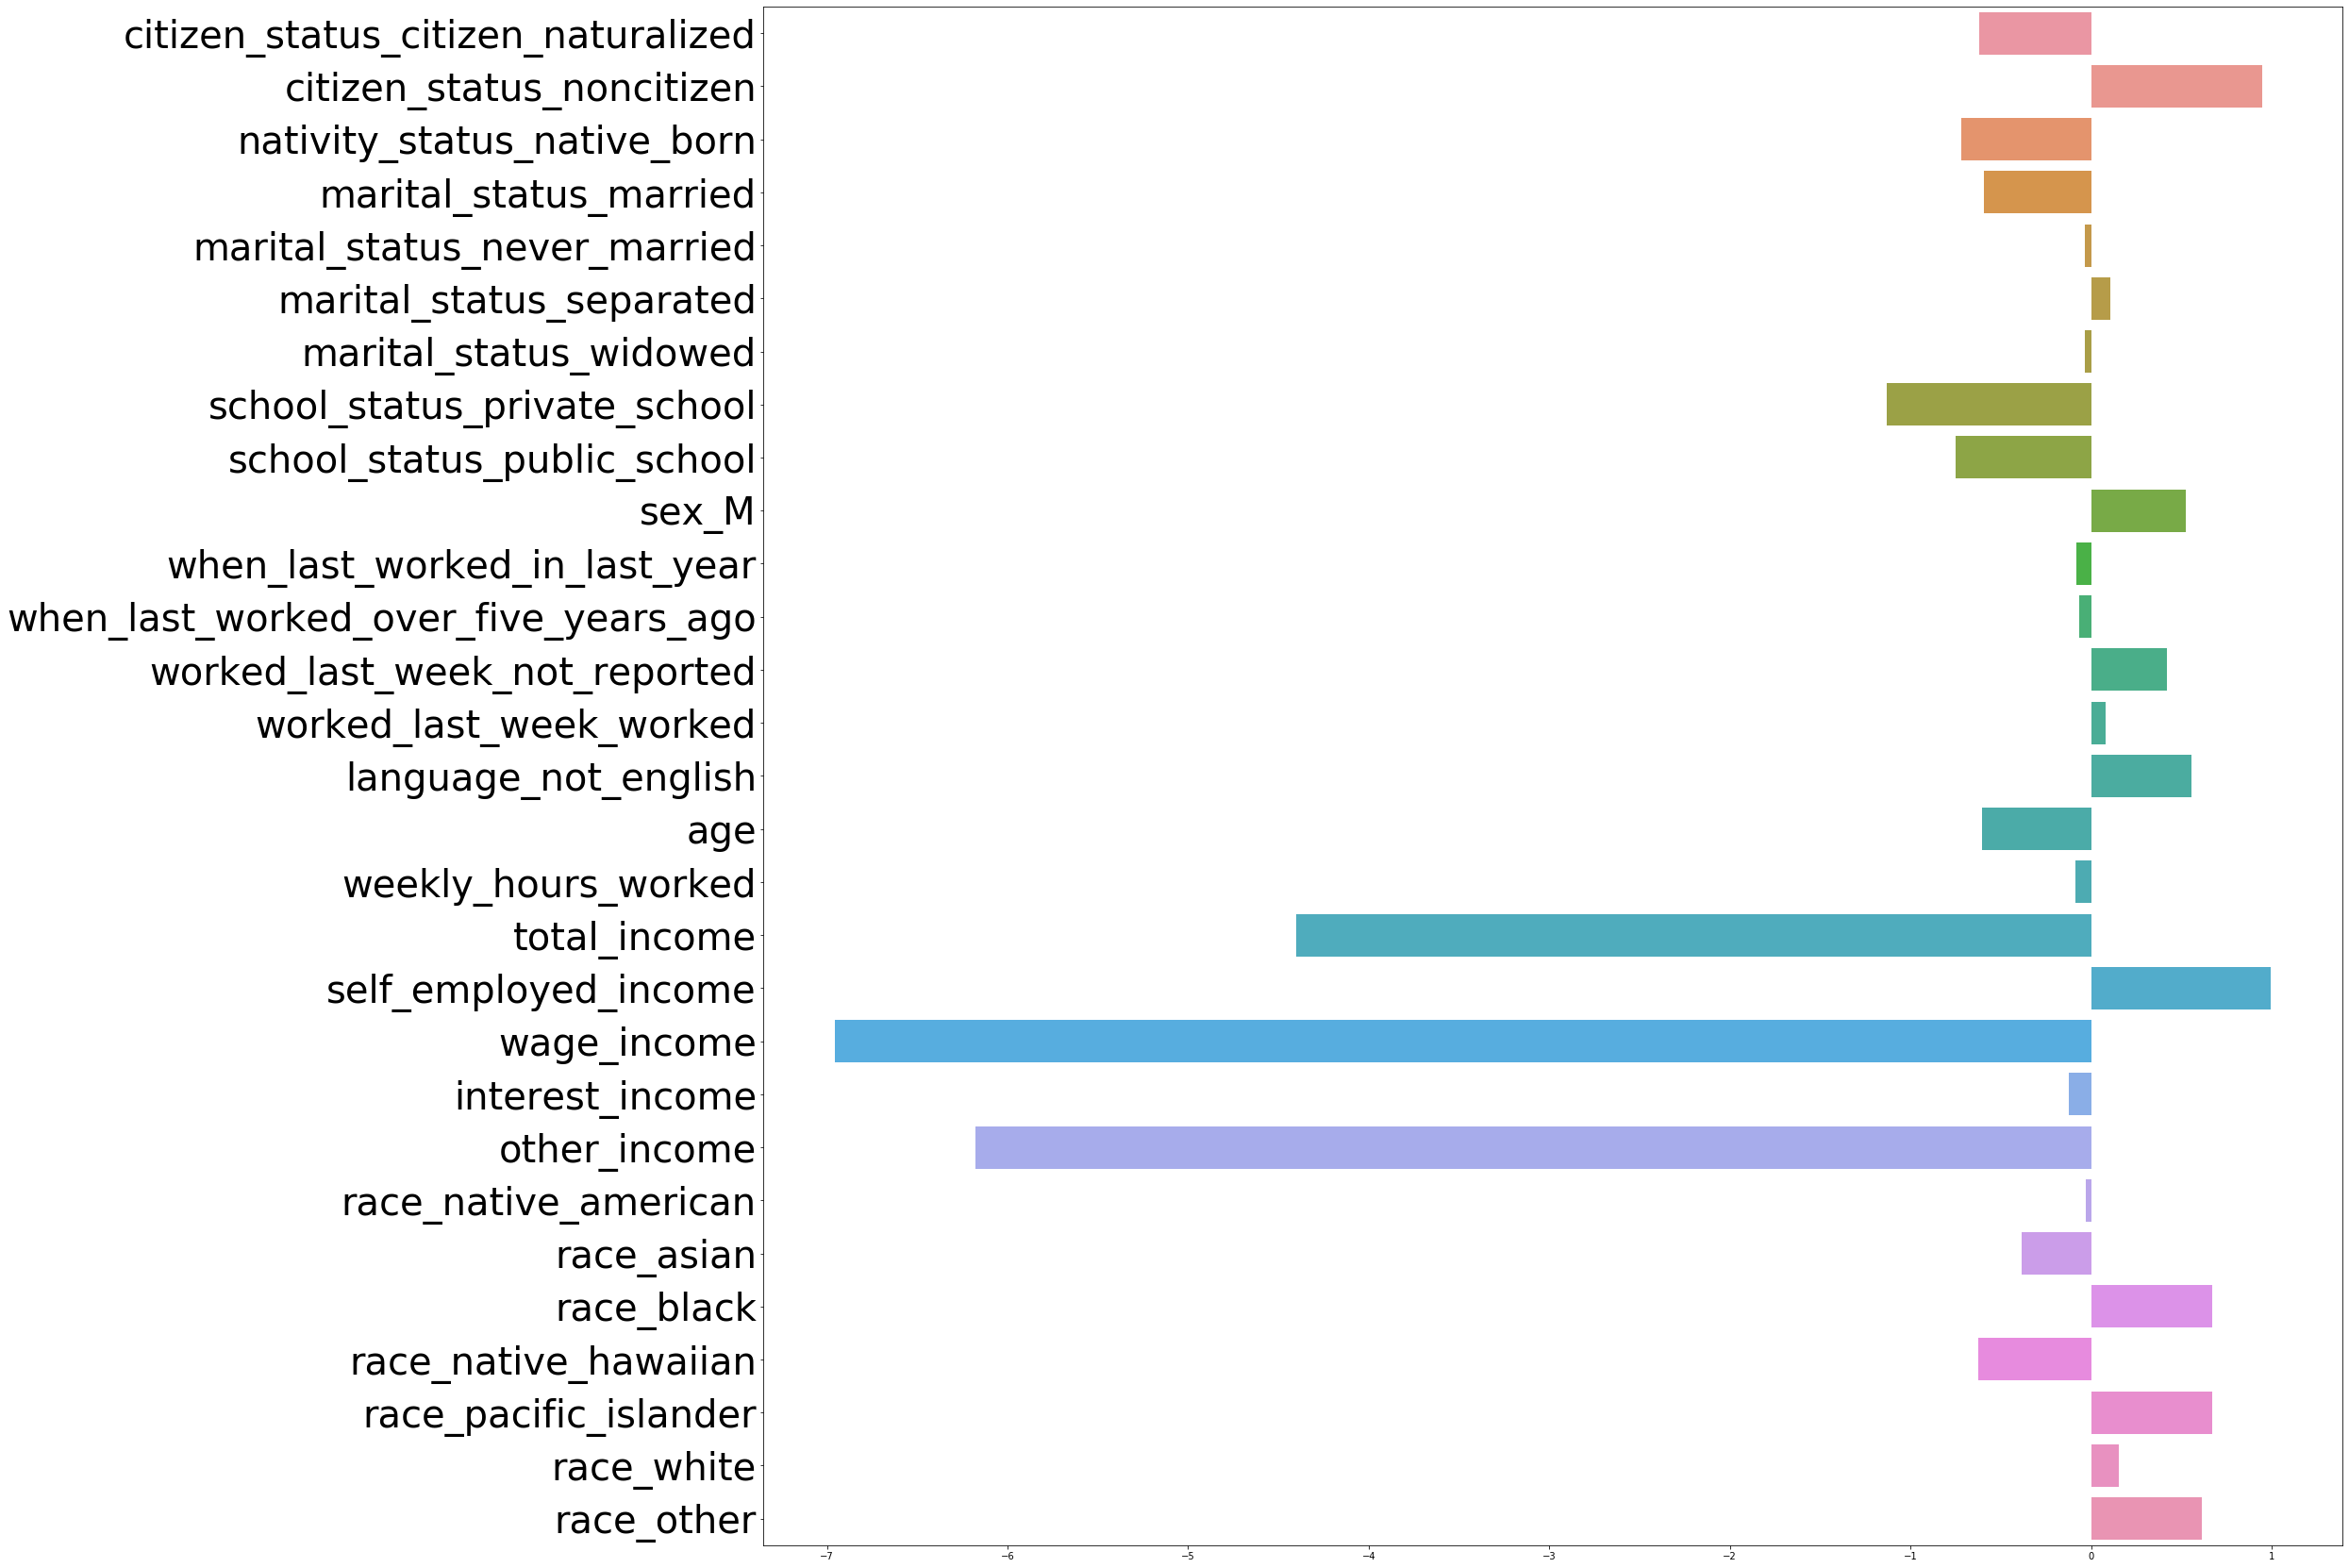

In [920]:
plt.figure(figsize=(30,30))
sns.barplot(x=coef, y=X_train.columns)
plt.yticks(fontsize=40)
plt.show()

0: Has health insurance.


1: Does not have health insurance.

A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease

In [921]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (11,7), fontsize=19):
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, cmap='YlGnBu')
        sns.set(font_scale=2)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    
    plt.ylabel('True label', fontsize=13)
    plt.xlabel('Predicted label', fontsize=13)
    
    return fig

In [923]:
log_classes = logreg.classes_

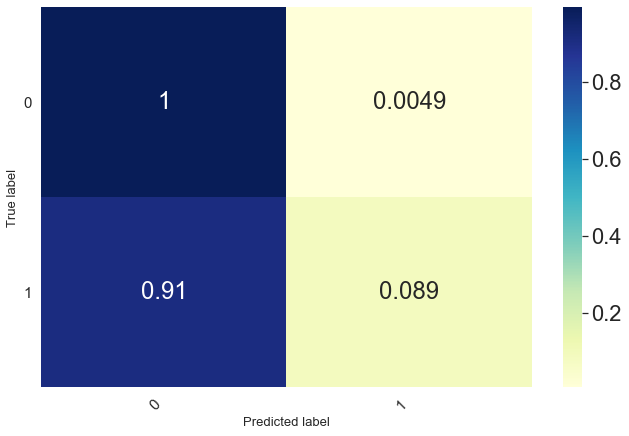

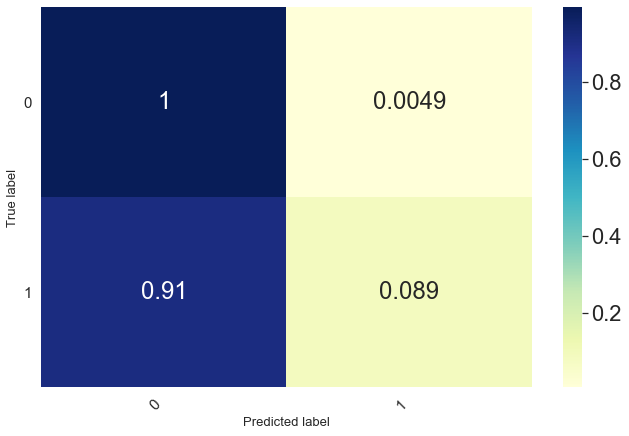

In [926]:
print_confusion_matrix(log_confusion, log_classes, figsize =(11,7), fontsize=15, )

#true p = 1
#false p = 0.004

# false n = 0.91
# true n = 0.089

In [710]:
unlabeled.head(2)

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,household_id
0,12,28,citizen_birth,native_born,45,15254.0,15081.0,82.0,16.0,75.0,never_married,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,6
1,13,40,citizen_birth,native_born,32,10291.0,45.0,9068.0,57.0,1121.0,divorced,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,7


In [711]:
unlabeled.sex = unlabeled.sex.replace({'FEMALE': 'F'})
unlabeled.sex = unlabeled.sex.replace({'female': 'F'})

unlabeled.sex = unlabeled.sex.replace({'MALE': 'M'})
unlabeled.sex = unlabeled.sex.replace({'male': 'M'})

unlabeled.head()

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,household_id
0,12,28,citizen_birth,native_born,45,15254.0,15081.0,82.0,16.0,75.0,never_married,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,6
1,13,40,citizen_birth,native_born,32,10291.0,45.0,9068.0,57.0,1121.0,divorced,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,7
2,22,68,citizen_birth,native_born,0,13194.0,80.0,34.0,69.0,13011.0,married,not_student,M,over_five_years_ago,did_not_work,English,0,0,0,0,0,1,0,13
3,23,64,citizen_birth,native_born,40,30194.0,33.0,30094.0,37.0,30.0,married,not_student,F,in_last_year,worked,English,0,0,0,0,0,1,0,13
4,25,29,citizen_birth,native_born,40,52174.0,12.0,52101.0,52.0,9.0,never_married,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,15


In [712]:
for val in unlabeled.language.values:
    if val != 'English':
        unlabeled.language = unlabeled.language.replace({val:'not_english'})

In [713]:
unlabeled_new = unlabeled.drop(['person_id', 'household_id'], axis=1)

In [714]:
cont = unlabeled_new.select_dtypes(exclude='object')

cat = unlabeled_new.select_dtypes(include='object')

In [597]:
for col in cont.columns:
    cont[col]= (cont[col]-min(cont[col]))/(max(cont[col]-min(cont[col])))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [598]:
ehe = OneHotEncoder(drop='first')
tran = ehe.fit_transform(cat).toarray()
tran_df= pd.DataFrame(tran, columns=ehe.get_feature_names(cat.columns))
tran_df.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,marital_status_married,marital_status_never_married,marital_status_separated,marital_status_widowed,school_status_private_school,school_status_public_school,sex_M,when_last_worked_in_last_year,when_last_worked_over_five_years_ago,worked_last_week_not_reported,worked_last_week_worked,language_not_english
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [599]:
tran_df.reset_index(inplace=True, drop=True)


In [600]:
cont.reset_index(inplace=True, drop=True)

In [601]:
new = tran_df.join(cont)

In [602]:
new.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,marital_status_married,marital_status_never_married,marital_status_separated,marital_status_widowed,school_status_private_school,school_status_public_school,sex_M,when_last_worked_in_last_year,when_last_worked_over_five_years_ago,worked_last_week_not_reported,worked_last_week_worked,language_not_english,age,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.131579,0.454545,0.014366,0.048633,0.000162,0.000065,0.000353,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.289474,0.323232,0.009685,0.000145,0.017953,0.000233,0.005276,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [603]:
%store new

Stored 'new' (DataFrame)


In [619]:
predictions = logreg.predict_proba(new)

predicted = logreg.predict(new)

predicted

array([0, 0, 0, ..., 0, 0, 0])

In [633]:
df = pd.DataFrame(predictions)

df['person_id'] = unlabeled.person_id

df['score'] = predicted


pd.set_option('display.max_rows', 500)

df

,0,1,person_id,score
0,0.827003,0.172997,12,0
1,0.860783,0.139217,13,0
2,0.955657,0.044343,22,0
3,0.971655,0.028345,23,0
4,0.941458,0.058542,25,0
...,...,...,...,...
20167,0.989266,0.010734,126592,0
20168,0.981605,0.018395,126623,0
20169,0.982541,0.017459,126624,0
20170,0.953252,0.046748,126640,0


The first column corresponds to the probability that the sample belongs to the first class and the second column corresponds to the probability that the sample belongs to the second class.

Please write your answers in this document, and include your code (including any exploratory or
data-munging code) as part3_code.txt. 


In addition, please apply your model to the observations in
unlabeled_data.csv to produce individual probability predictions of uninsurance. 

After that, place
the person_id column and the associated scores into a file called part3_scores.csv. The headers on
this csv should be “person_id” and “score” for person_id and predicted scores, respectively.

In [720]:
# from sklearn import svm

# #Create a svm Classifier
# clf = svm.SVC(kernel='rbf', probability=True) # Linear Kernel

# #Train the model using the training sets
# clf.fit(X_train, y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(X_test)

In [721]:
# clf.score(X_test, y_test)

In [719]:
# from sklearn import metrics

# # Model Accuracy: how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [715]:
# # Model Precision:
# print("Precision:",metrics.precision_score(y_test, y_pred))

# # Model Recall
# print("Recall:",metrics.recall_score(y_test, y_pred))

In [716]:
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# log_confusion = confusion_matrix(y_test, y_pred, normalize='true')
# class_report = classification_report(y_test, y_pred)

# print(log_confusion)
# print(class_report)

In [717]:
# predictions = clf.predict_proba(new)

# predicted = clf.predict(new)

# predicted

In [718]:
# df = pd.DataFrame(predictions)

# df['person_id'] = unlabeled.person_id

# df['score'] = predicted


# pd.set_option('display.max_rows', 500)

# # df.head(50)